In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.data import Dataset
import matplotlib.pyplot as plt

from process.c_parse import parse_input as c_parse
from db.driver import Driver

%matplotlib inline

DIMENSION = 64

In [2]:
driver = Driver()

In [3]:
class Line:
    def __init__(self, start, end):
        self.__cache = {}
        self.start = start
        self.end = end
    
    def __cached(function):
        def cached_function(*argv, **kw):
            cache = argv[0].__cache
            token = tuple([function.__name__] + list(argv[1:]))
            if token not in cache:
                cache[token] = function(*argv, **kw)
            return cache[token]
        return cached_function
    
    @__cached
    def __step(self):
        vector = [e - s for s, e in zip(self.start, self.end)]
        if vector[0]:
            vector[1] /= float(abs(vector[0]))
            vector[0] /= abs(vector[0])
        elif vector[1]:
            vector[1] /= abs(vector[1])
        return vector
    
    def __check(self, x, y):
        vector = self.__step()
        if vector[0] > 0:
            return x <= self.end[0]
        elif vector[0] < 0:
            return x >= self.end[0]
        elif vector[1] > 0:
            return y <= self.end[1]
        return y >= self.end[1]
            
    def __iter__(self):
        if self.start == self.end: 
            yield self.start
        else:
            dx, dy = self.__step()
            x, y = self.start
            while self.__check(x, y):
                yield x, int(round(y))
                x, y = x + dx, y + dy

def expand_to_image_matrix(drawing):
    matrix = np.zeros(DIMENSION * DIMENSION)
    for stroke in drawing:
        prev = (stroke[0][0], stroke[1][0])
        for i in xrange(1, len(stroke[0])):
            current = (stroke[0][i], stroke[1][i])
            for x, y in Line(prev, current):
                matrix[y * DIMENSION + x] = 1
            prev = current
    return matrix

In [4]:
def display_strokes(drawing):
    plt.axis('off')
    plt.gca().invert_yaxis()
    for stroke in drawing:
        plt.plot(*stroke, color='black')
    plt.show()

INFO:tensorflow:Restoring parameters from ./model/sketch_cnn.model-3000


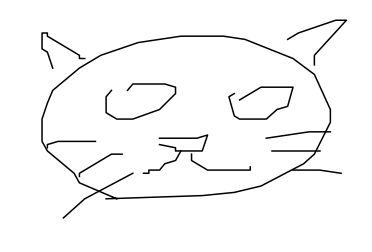

['cat', 'basketball', 'envelope']


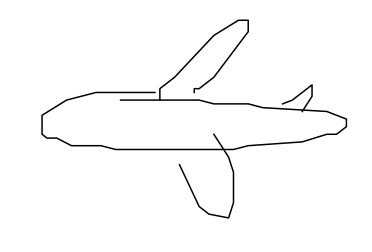

['airplane', 'flower', 'cat']


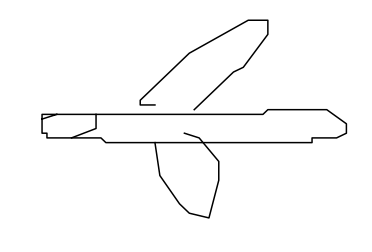

['airplane', 'cat', 'envelope']


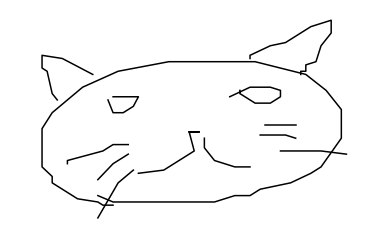

['cat', 'basketball', 'airplane']


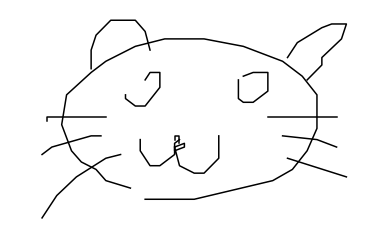

['cat', 'basketball', 'diamond']


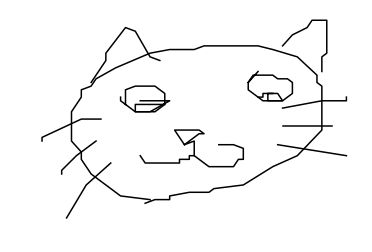

['cat', 'basketball', 'airplane']


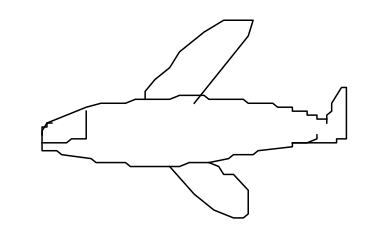

['airplane', 'basketball', 'cat']


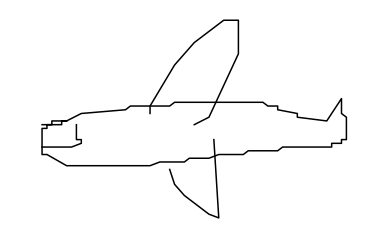

['airplane', 'cat', 'basketball']


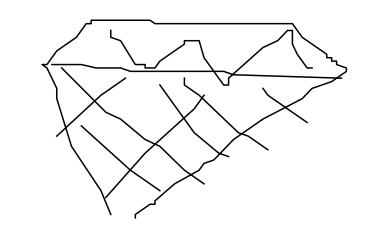

['diamond', 'basketball', 'flower']


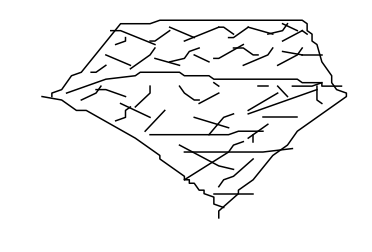

['diamond', 'basketball', 'flower']


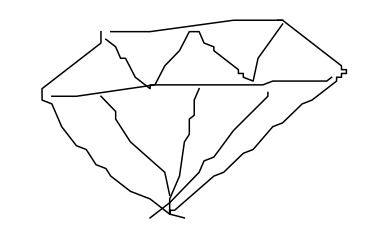

['diamond', 'basketball', 'flower']


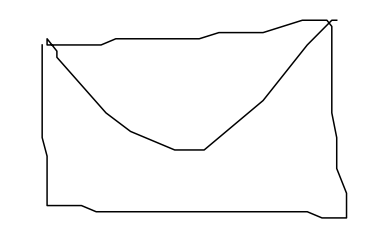

['envelope', 'airplane', 'basketball']


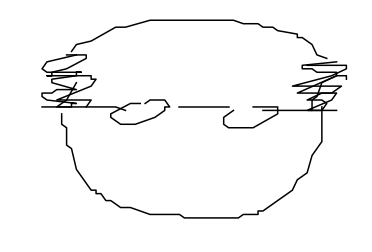

['basketball', 'diamond', 'cat']


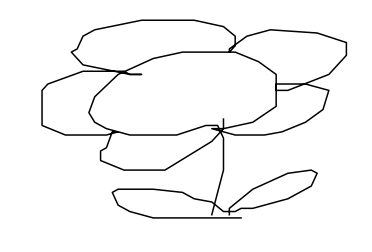

['basketball', 'flower', 'cat']


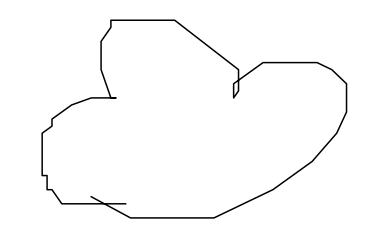

['airplane', 'envelope', 'flower']


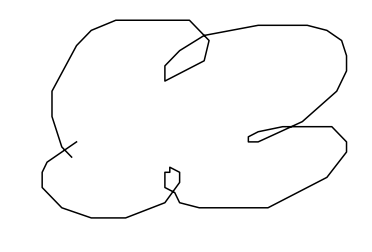

['basketball', 'flower', 'airplane']


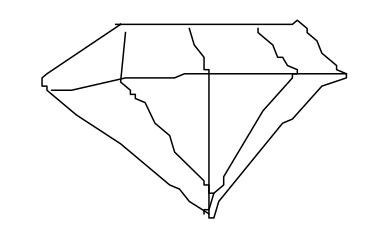

['diamond', 'basketball', 'flower']


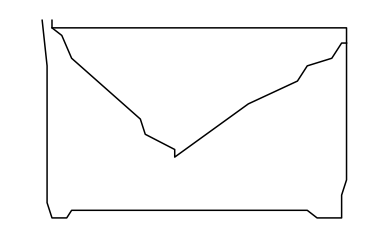

['envelope', 'airplane', 'basketball']


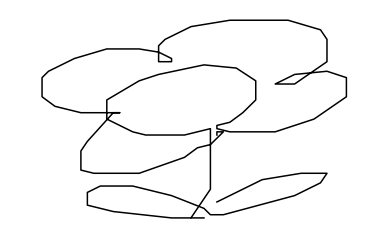

['flower', 'basketball', 'cat']


In [7]:
saver = tf.train.import_meta_graph(tf.train.latest_checkpoint('./model')+ '.meta')
NUM_CLASSES = 6

TYPE = ['airplane', 'basketball', 'cat', 'diamond', 'envelope', 'flower']

with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('./model'))
    
    graph = tf.get_default_graph()
    accuracy = graph.get_tensor_by_name('accuracy:0')
    x = graph.get_tensor_by_name('x:0')
    y_ = graph.get_tensor_by_name('y_:0')
    y_conv = graph.get_tensor_by_name('y_conv:0')
    keep_prob = graph.get_tensor_by_name('k:0')
    
    with open('./data/strokes.txt', 'r') as f:
        for line in f:
            drawing = c_parse(line, normalize=True, RDP=True, epsilon=0.5)
            batch = tuple([expand_to_image_matrix(drawing)])
            score = y_conv.eval(feed_dict={x: batch, y_: np.zeros((1, 6)), keep_prob: 1.0})[0]
            result = [TYPE[a] for a in sorted(range(len(score)), key=lambda x: -score[x])[:3]]
            
            display_strokes(drawing)
            print result